# Sintonía de controladores PID con base en los modelos de curva de reacción


En esta práctica vamos a obtener los modelos por curva de reacción y los modelo estáticos para un sistema térmico y, también, para un motor DC considerando como sañlida la velocidad. Usaremos las plantas diseñadas en la universidad llamadas UNThermal y UNDCMotor

+ El UNThermal es un minilaboratorio que permite realizar el control de temperatura de un par transistor-sensor mediante la administración precisa de potencia eléctrica controlada por una fuente de corriente. 

+ El UNDCMotor es un minilaboratorio que permite realizar el control de velocidad y ángulo de giro de un motor DC. 


## 1. Configuración

---


### Instalación de las librerias unthermal y unmotor

Descomentar y ejecutar esta celda solo para instalar por primera vez o actualizar las librerias. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__



In [1]:
import subprocess
command = ["pip", "install", "-I", "git+https://github.com/nebisman/UNThermal.git@main#subdirectory=code/python_code"]
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line.strip())

command = ["pip", "install", "-I", "git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code"]
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line.strip())

Cloning https://github.com/nebisman/UNThermal.git (to revision main) to /tmp/pip-req-build-dc695un4
Running command git clone --filter=blob:none --quiet https://github.com/nebisman/UNThermal.git /tmp/pip-req-build-dc695un4
Resolved https://github.com/nebisman/UNThermal.git to commit c0acc22d6b7a0643ea071e24f5370441f8856f6f
Installing build dependencies: started
Installing build dependencies: finished with status 'done'
Getting requirements to build wheel: started
Getting requirements to build wheel: finished with status 'done'
Preparing metadata (pyproject.toml): started
Preparing metadata (pyproject.toml): finished with status 'done'
Using cached iottalk_paho_mqtt-1.5.1-py3-none-any.whl.metadata (46 kB)
Using cached control-0.10.1-py3-none-any.whl.metadata (7.6 kB)
Using cached numpy-2.2.4-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached matplotlib-3.10.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached sc


### Importación de comandos de la libreria unthermal y unmotor

A continuación importamos los comandos básicos que usaremos de la libreria `unthermal` y la libreria `Matplotlib` para las figuras.

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import unthermal as temp
import unmotor as motor


### Definición de los sistemas en el IoT

Lo primero que necesitamos es definir tanto el sistema térmico como el motor en el IoT

In [3]:
mi_termico = temp.ThermalSystemIoT(plant_number = "PC-T-10" , broker_address = "192.168.0.14", port=1883)


print(mi_termico.transfer_function())

<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  1.048
----------
32.2 s + 1



## Sintonia de controladores PI con base en el modelo FOTD

---
### Breve teoría -- control PID

Uno de los algoritmos de control más usuales es el control **PID** en el cual la señal de control aplicada es proporcional al error, a su integral y a su derivada, según la expresión:
\begin{align*}
u(t) &= P + I + D\\
u(t) &= k_p\,e(t) + k_i\,\int_0^t{e(\lambda)\,d\lambda} + k_d\, \dfrac{de(t)}{dt}
\end{align*}

La estructura del controlador se muestra en la figura siguiente:

<img src="https://github.com/nebisman/UNThermal/blob/main/code/python_code/notebooks_lab_2024_2/pid1gdl.png?raw=true" alt="PID" width="500"/>



  
### Sintonía según el método de Ziegler-Nichols por respuesta al escalón

El método más antiguo para *sintonizar* un PID, es decir, de ajustar las constantes de un controlador PID es el método de la respuesta al escalón de **Ziegler y Nichols (1948)**. Según este método, para un controlador unicamente proporcional (P) o uno proporcional e integral (PI), las constantes $k_p$ y $k_i$ se ajustan, respectivamente, de acuerdo con la tabla siguiente.


| **Tipo de Controlador** | **Ganancia Proporcional** $k_p$                | **Ganancia Integral** $k_i$                | 
|-------------------------|------------------------------------------------|--------------------------------------------|
| **P** solo proporcional                    | $\dfrac{\tau}{\alpha L}$                 | $0$                                  | 
| **PI** proporcional e integral                  | $0.9 \times \dfrac{\tau}{\alpha L}$      | $ \dfrac{0.3 \, \tau}{\alpha \, L^2}$ |


Note que los parámetros del controlador se expresan en términos de las constantes $\alpha$, $\tau$ y $L$ obtenidas experimentalmente a partir de un modelo **FOTD** como el de la práctica anterior, es decir, por medio de las constantes del siguiente modelo:

$$G(s)=\frac{\alpha}{\tau\,s+1} e^{-L\,s}$$

Cuya respuesta se ilustra en la figura siguiente: 

<img src="https://github.com/nebisman/UNThermal/blob/main/docs/primer_orden_delay.png?raw=true" alt="Gráfica de resultados" width="500"/>











Una descripción completa la encuentra en el capítulo 6 del libro de **Control PID Avanzado** de la bibliografía. En [este fragmento](https://drive.google.com/file/d/1QwG9kX1Oqav6lfPNQsxBqlAMWaGTstdD/view?usp=sharing) se presenta especifícamente el método de Ziegler y Nichols.  


A continuación vamos a ver la respuesta en lazo cerrado del sistema térmico con un controlador PI, siguiendo el método de Ziegler-Nichols.




Successfully connected to MQTT Broker 192.168.0.14
Command send:  1
PID parameters changed
Successfully connected to MQTT Broker 192.168.0.14
Subscribed:  2   (2,)
Command send:  3


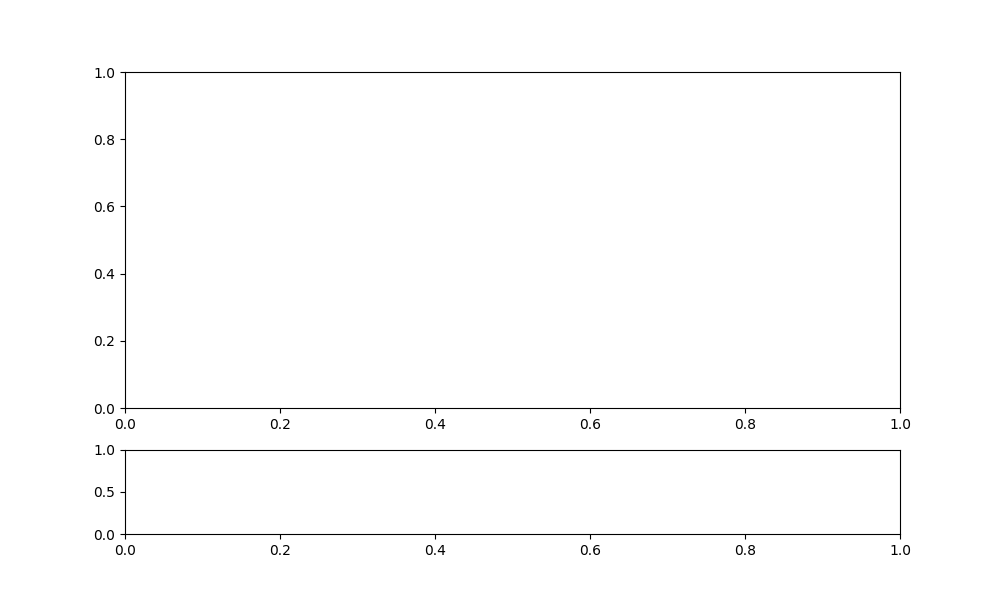

In [4]:
# Reglas de Ziegler - Nichols para un controlador PI

# estos son los parámetros del modelo que obtuvimos en nuestro experimento
alfa = 1.36
tau = 35.89
L = 0.54

# Calculamos las constantes según el método de Ziegler-Nichols

kp_zn = 0.9*tau / (alfa * L)  # constante proporcional
ki_zn = 0.3*tau / (alfa * L**2) # constante integral 

# programamos los parámetros del PID con el siguiente comando
temp.set_pid(mi_termico,kp=kp_zn, ki=ki_zn, kd=0, beta=1)

# Ahora obtenemos la respuesta al escalón 

r0 = 50 # valor inicial del escalón de referencia antes del cambio (grados celsius)
t0 = 60 # tiempo que dura en el valor inicial

r1 = 60 # valor final del escalón de referencia  (grados celsius)
t1 = 60 # tiempo que demora en el valor final

# con este comando obtenemos la respuesta al escalón
t_zn, r_zn, y_zn, u_zn = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1)

### Otros métodos de sintonía 

Existen una infinidad de métodos de sintonía. Con base en propuesta de Ziegler y Nichols han seguido apareciendo nuevas propuestas de sintonía que preservan la filosofía del método original en cuanto a su simplicidad. La tabla siguiente contiene algunos métodos de sintonización reportados en la literatura para controladores PI.

| **Propuesto por** | **Ganancia Proporcional** $k_p$                | **Ganancia Integral** $k_i$                | 
|-------------------------|------------------------------------------------|--------------------------------------------|
| **Skogestad (2003)**           |   $\dfrac{0.5\,\tau}{\alpha\,L}$   | $\dfrac{k_p}{\min(\tau, 8\,L)}$ |
| **Zhang  (1994)**           |   $\dfrac{\tau}{\alpha\,L}$  | $\dfrac{k_p}{\tau}$|
|**Åström and Hägglund (2006)**                | $\dfrac{0.15}{\alpha} + \left(0.35 - \dfrac{L \cdot \tau}{(L + \tau)^2}\right) \dfrac{\tau}{\alpha \cdot L} $               |  $\dfrac{k_p}{0.35 \cdot L + \frac{13 \cdot L \cdot \tau^2}{\tau^2 + 12 \cdot L \cdot \tau + 7 \cdot L^2}}$   

### Trabajo experimental con el sistema térmico

Realice los siguientes experimentos con un escalón que cambia desde `r0=50` a `r1=60`.  Para cada uno de los 3 experimentos use nombres diferentes en las variables de salida para poder graficar conjuntamente cada experimento. Por ejemplo, para el experimento 1 puede usar:

`t_sk, r_sk, y_sk, u_sk = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1)`


1. Sintonice un controlador PI por el método de Skogestad y obtenga la respuesta al escalón en lazo cerrado.
 con un escalón que cambia desde `r0=50` a `r1=60`.

1. Sintonice un controlador PI por el método de Taguchi y Araki y obtenga la respuesta al escalón en lazo.

1. Sintonice un controlador PI por el método de Åström and Hägglund y obtenga la respuesta al escalón en lazo cerrado.

#### Preguntas orientadoras

+ Grafique en la misma figura las respuestas al escalón en lazo cerrado de los 4 experimentos anteriores (incluido el de Ziegler-Nichols) 

+ Con base en la grafica de la pregunta anterior, evalue los 4 métodos de sintonia, dando una puntuación de 1 a 10 a cada uno. Explique esta puntuación.

+ ¿Según el experimento, podemos afirmar que el método de Ziegler-Nichols es robusto?

### ¿Por qué usar acción integral?

Una de las acciones fundamentales de control es la acción integral $I = k_i \int_0^t e(\lambda)d\lambda$. Vamos a realizar el siguiente experimento, para observar el papel de la acción integral.

In [ ]:
# reglas de Astrom para PI - sistema termico
print(alfa,tau,L)
kp = 0.15/alfa + (0.35 - L*tau/(L+tau)**2)*tau/(alfa*L) 
ki = kp /(0.35*L + 13*L*tau**2/(tau**2+12*L*tau + 7*L**2))
print(kp,ki)
temp.set_pid(mi_termico,kp=15,ki=0,kd=0,beta=1)
t_as, r_as, y_as, u_as = temp.step_closed(mi_termico,r0=40,r1=50,t0=60,t1=60)

## Modelo FOTD según la literatura


$G(s) = \frac{K_m}{T_m\, s+1}e^{-s\tau_m}$ 

In [ ]:
# reglas de Skogestad para PI - sistema termico
print(alfa,tau,L)
kp = 0.5*tau/(alfa * L)
ki = np.min([tau ,8*L])
print(kp,ki)
temp.set_pid(mi_termico,kp=kp,ki=ki,kd=0,beta=0)
t_sk, r_sk, y_sk, u_sk = temp.step_closed(mi_termico,r0=50,r1=60,t0=60,t1=60)

In [ ]:
plt.figure()
plt.plot( t_as,r_as,t_zn, y_zn, t_as, y_as, t_sk, y_sk)
plt.xlim([0, t0+t1])
plt.grid(True)
plt.legend([ "Reference","Ziegler-Nichols", "Astrom"])
plt.show()

In [ ]:
# reglas de Skogestad para PI - sistema termico
print(alfa,tau,L)
kp = 0.5*tau/(alfa * L)
ki = np.min([tau ,8*L])
print(kp,ki)
temp.set_pid(mi_termico,kp=kp,ki=ki,kd=0,beta=1)
t, r, y, u = temp.step_closed(mi_termico,r0=60,r1=70,t0=60,t1=60)

In [ ]:
# Taguchi et Araki (2000) - sistema termico intermedio
L=0.02
alfa = 300
tau= 0.13
kp = (0.1787 + 0.2839/(L/tau + 0.001723)) / alfa 
ki = kp/(4.296+ 3.794 *L/tau + 0.2591 * (L/tau)**2) 
print(kp,ki)
temp.set_pid(mi_termico,kp=kp,ki=ki,kd=0,beta=0)
t, r, y, u = temp.step_closed(mi_termico,r0=60,r1=70,t0=60,t1=60)


In [ ]:
## Modelo del motor

alfa, tau, L = motor.get_fomodel_step(mi_motor, yop = 360)

In [ ]:
# Reglas de Ziegler Nichols para el motor
print(alfa,tau,L)
kp = tau/(alfa*L)
ki = tau
print(kp,ki)
motor.set_pid(mi_motor,kp=kp,ki=ki,kd=0,beta=0, output="speed")
motor.step_closed(mi_motor,r0=0, r1=360, t0=1, t1=2);

In [ ]:
#reglas de astrom para el motor
print(alfa,tau,L)
kp =0.0051
ki=0
print(kp,ki)
motor.set_pid(mi_motor,kp=kp,ki=ki,kd=0,beta=1, output="speed")
motor.step_closed(mi_motor,r0=0, r1=360, t0=1, t1=2);

In [ ]:

# reglas de Skogestad para PI - motor
print(alfa,tau,L)
kp = 0.5*tau/(alfa * L)
ki = kp/np.min([tau ,8*L])
print(kp,ki)
motor.set_pid(mi_motor,kp=kp,ki=ki,kd=0,beta=1, output="speed")
motor.step_closed(mi_motor,r0=0, r1=360, t0=1, t1=2);

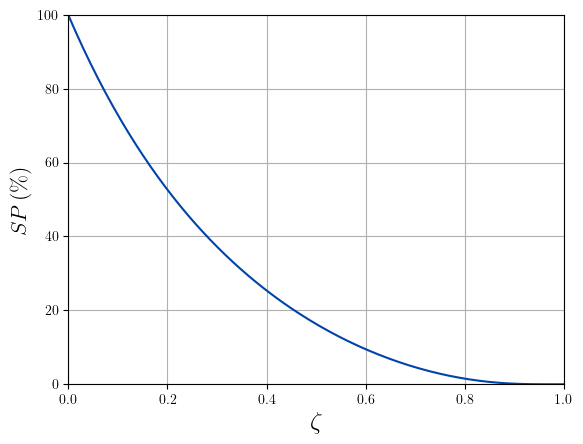

In [43]:
import numpy as np
import matplotlib.pyplot as plt



z = np.linspace(0,0.999,200)
SP = 100* np.exp((-np.pi*z/np.sqrt(1-z**2)))
plt.figure()
plt.plot(z,SP, color="#0044aa")
plt.xlim([0,1])
plt.ylim([0,100])
plt.grid(True)
plt.xlabel(r"$\zeta$", fontsize=18)
plt.ylabel(r"$SP \,(\%)$", fontsize=16)
plt.savefig("sobrepico.pdf", format="pdf", bbox_inches="tight") # la figura se guarda en el archivo que ud desee

plt.show()